
# Interpretability Seminar

This notebook has two parts:

1. **Attention head visualisation** – we load a GPT‑2 model and visualise its attention patterns.  The goal is to identify phenomena such as attention sinks, copy/induction heads, and positional biases.
2. **Causal interventions and feature steering** – we perform activation patching on the Indirect Object Identification (IOI) task to locate where the model resolves pronoun reference, and we demonstrate simple feature steering through head ablation.

In [2]:
!pip install -q torch matplotlib transformer_lens transformers circuitsvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.0/192.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 66.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 

In [1]:
import torch
import matplotlib.pyplot as plt
from transformer_lens import HookedTransformer
import transformers

import IPython.display as ipd
import circuitsvis as cv

model = HookedTransformer.from_pretrained("gpt2")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Loaded pretrained model gpt2 into HookedTransformer
Moving model to device:  cuda


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

In [2]:
text = "When Mary and John went to the store, John gave a drink to"
model.generate(text)

  0%|          | 0/10 [00:00<?, ?it/s]

'When Mary and John went to the store, John gave a drink to Mary and said, Vincent, I have come here'

In [3]:
def visualise_attention(layer):
    assert layer in list(range(12))
    _, cache = model.run_with_cache(tokens)
    pattern = cache[f"blocks.{layer}.attn.hook_pattern"] # (batch, heads, Q_len, K_len)
    str_tokens = model.to_str_tokens(tokens)
    a = cv.attention.attention_patterns(tokens=str_tokens, attention=pattern[0])
    return a


text = "When Mary and John went to the store, John gave a drink to Mary."
tokens = model.to_tokens(text).to(device)

layer = 0
ipd.display(visualise_attention(layer));

### Attention heads (1 point)
Your task is to find the following attention heads (and please plot corresponding attention pattern):
- The earliest that attend to first Mary while generating second *
- Attention sink head
- Positional-bias head
- Induction head
- Punctuation-tracking head

In [4]:
for layer in range(model.cfg.n_layers):
    # average attention weight on token 0 across heads and positions
    _, cache = model.run_with_cache(tokens)
    pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
    first_tok_attn = pattern[0, :, :, 0].mean().item()
    print(f"Layer {layer}: avg attention on first token = {first_tok_attn:.2f}")


Layer 0: avg attention on first token = 0.30
Layer 1: avg attention on first token = 0.42
Layer 2: avg attention on first token = 0.34
Layer 3: avg attention on first token = 0.53
Layer 4: avg attention on first token = 0.56
Layer 5: avg attention on first token = 0.75
Layer 6: avg attention on first token = 0.69
Layer 7: avg attention on first token = 0.84
Layer 8: avg attention on first token = 0.73
Layer 9: avg attention on first token = 0.80
Layer 10: avg attention on first token = 0.78
Layer 11: avg attention on first token = 0.67


In [10]:
tokens = model.to_tokens(text).to(device)

# считаем cache
_, cache = model.run_with_cache(tokens)
str_tokens = model.to_str_tokens(tokens)
if len(str_tokens) > 0 and isinstance(str_tokens[0], list):
    str_tokens = str_tokens[0]

def show_head(layer, head):
    pat = cache[f"blocks.{layer}.attn.hook_pattern"][0, head:head+1]
    return cv.attention.attention_patterns(tokens=str_tokens, attention=pat)

def best_over_layers_heads(score_LH):
    idx = score_LH.argmax().item()
    H = score_LH.shape[1]
    return idx // H, idx % H, score_LH.flatten()[idx].item()


In [11]:
# The earliest that attend to first Mary while generating second *

mary_pos = [i for i, t in enumerate(str_tokens) if "Mary" in t]
first_mary = mary_pos[0]
second_mary = mary_pos[1]
q = max(0, second_mary - 1)

scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)
for L in range(model.cfg.n_layers):
    pat = cache[f"blocks.{L}.attn.hook_pattern"][0]
    qq = min(q, pat.shape[1]-1)
    scores[L] = pat[:, qq, first_mary]

mx = scores.max().item()
thr = 0.8 * mx
cands = [(L, H, scores[L, H].item())
          for L in range(model.cfg.n_layers) for H in range(model.cfg.n_heads)
          if scores[L, H].item() >= thr]
cands.sort(key=lambda x: (x[0], -x[2]))
L, H, val = cands[0]

print(f"[Earliest Mary->Mary] layer={L}, head={H}, attn={val:.4f} (max={mx:.4f})")
ipd.display(show_head(L, H))


[Earliest Mary->Mary] layer=9, head=6, attn=0.6719 (max=0.8249)


In [14]:
# Attention sink head

sink = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)
for L in range(model.cfg.n_layers):
    pat = cache[f"blocks.{L}.attn.hook_pattern"][0]
    sink[L] = pat[:, :, 0].mean(dim=1)

L, H, val = best_over_layers_heads(sink)
print(f"[Attention sink] layer={L}, head={H}, score={val:.4f}")
ipd.display(show_head(L, H))

[Attention sink] layer=7, head=2, score=0.9949


In [15]:
# Positional-bias head

pos = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)
for L in range(model.cfg.n_layers):
    pat = cache[f"blocks.{L}.attn.hook_pattern"][0]
    diag = torch.diagonal(pat, offset=-1, dim1=-2, dim2=-1)
    pos[L] = diag.mean(dim=1)

L, H, val = best_over_layers_heads(pos)
print(f"[Positional-bias prev] layer={L}, head={H}, score={val:.4f}")
ipd.display(show_head(L, H))

[Positional-bias prev] layer=4, head=11, score=1.0000


In [17]:
# Punctuation-tracking head

punct_positions = [i for i,t in enumerate(str_tokens) if any(ch in t for ch in [",", "."])]
punct_pos_t = torch.tensor(punct_positions, device=device)
punct = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)

for L in range(model.cfg.n_layers):
    pat = cache[f"blocks.{L}.attn.hook_pattern"][0]
    punct[L] = pat[:, :, punct_pos_t].sum(dim=-1).mean(dim=-1)

L, H, val = best_over_layers_heads(punct)
print(f"[Punctuation-tracking] layer={L}, head={H}, score={val:.4f}, positions={punct_positions}")
ipd.display(show_head(L, H))

[Punctuation-tracking] layer=2, head=5, score=0.1913, positions=[9, 16]


In [20]:
# Induction head

# найдём 2 вхождения John
john_pos = [i for i,t in enumerate(str_tokens) if "John" in t]
first_john = john_pos[0]
second_john = john_pos[1]

k = min(first_john + 1, len(str_tokens)-1)
q = max(0, second_john - 1)

scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=device)
for L in range(model.cfg.n_layers):
    pat = cache[f"blocks.{L}.attn.hook_pattern"][0]
    qq = min(q, pat.shape[1]-1)
    scores[L] = pat[:, qq, k]

mx = scores.max().item()
thr = 0.8 * mx
cands = [(L, H, scores[L, H].item())
          for L in range(model.cfg.n_layers) for H in range(model.cfg.n_heads)
          if scores[L, H].item() >= thr]
cands.sort(key=lambda x: (x[0], -x[2]))
L, H, val = cands[0]

print(f"[induction on John] layer={L}, head={H}, attn={val:.4f}")
print(f"  first John pos={first_john}")
print(f"  target (after first John) pos={k}, token={str_tokens[k]}")
print(f"  query pos={q}, token={str_tokens[q]}")
ipd.display(show_head(L, H))


[induction on John] layer=4, head=9, attn=0.3726
  first John pos=4
  target (after first John) pos=5, token= went
  query pos=9, token=,


в тексте единственное повторяющееся слово - John. Когда встречаем второй John, смотрим на токен после первого John - went.


## Activation Patching and Feature Steering (2 points total)

Activation patching is *causal interventions* technique: run the model on a clean input (which exhibits correct behaviour) and a corrupted input (which exhibits incorrect behaviour), then replace a component of the corrupted run with the corresponding activation from the clean run.  If the model’s output is “fixed” by the patch, the replaced component is causal for the behaviour.

In [21]:
# IOI prompts
ioi_clean = "After John and Mary went to the store, Mary gave a bottle of milk to"
ioi_corrupt = "After John and Mary went to the store, John gave a bottle of milk to"
print(torch.where(model.to_tokens(ioi_clean) != model.to_tokens(ioi_corrupt))[1])

tensor([10], device='cuda:0')


In [22]:
clean_tokens = model.to_tokens(ioi_clean).to(device)
corrupt_tokens = model.to_tokens(ioi_corrupt).to(device)

# Utility to compute logit difference between " John" and " Mary"
def logits_to_logit_diff(logits):
    john_id = model.to_single_token(" John")
    mary_id = model.to_single_token(" Mary")
    final_logits = logits[0, -1, :]
    return float(final_logits[john_id] - final_logits[mary_id])

# Baseline predictions
clean_logits = model(clean_tokens)
corrupt_logits = model(corrupt_tokens)
print("Clean prompt logit diff (John vs Mary):", logits_to_logit_diff(clean_logits))
print("Corrupt prompt logit diff (John vs Mary):", logits_to_logit_diff(corrupt_logits))


Clean prompt logit diff (John vs Mary): 4.276432991027832
Corrupt prompt logit diff (John vs Mary): -2.7375869750976562


/tmp/ipython-input-3805381939.py:9: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  return float(final_logits[john_id] - final_logits[mary_id])


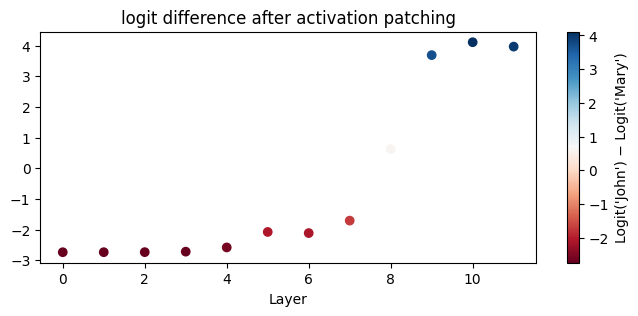

In [23]:
_, clean_cache = model.run_with_cache(clean_tokens)
_, corrupt_cache = model.run_with_cache(corrupt_tokens)

layers = model.cfg.n_layers
logit_diff_effect = torch.zeros((layers, 1))

pos = 10
for L in range(layers):

    # Hook function to replace the residual stream at (layer L)
    def patch_resid_hook(resid, hook, position=pos, layer=L):
        resid[:, position, :] = corrupt_cache[f"blocks.{layer}.hook_resid_pre"][:, position, :]
        return resid

    # Run corrupted prompt with the hook
    patched_logits = model.run_with_hooks(
        clean_tokens,
        fwd_hooks=[(f"blocks.{L}.hook_resid_pre", patch_resid_hook)]
    )

    # Measure logit difference after patching
    logit_diff_effect[L] = logits_to_logit_diff(patched_logits)

plt.figure(figsize=(8, 3))
plt.scatter(range(12), logit_diff_effect.squeeze().numpy(), cmap='RdBu', c=logit_diff_effect)
plt.colorbar(label="Logit('John') − Logit('Mary')")
plt.xlabel("Layer")
plt.title("logit difference after activation patching")
plt.show()



### Feature steering via head ablation (1 point)

Once we have identified a head or layer that contributes to a behaviour, we can *steer* the model by intervening on it.  For example, ablation removes a head’s influence by zeroing its output.  Conversely, we could amplify a head’s output to bias the model.


In [38]:
def generate_with_hooks(model: HookedTransformer, prompt: str, max_new_tokens: int, hooks)-> str:
    tokens = model.to_tokens(prompt)
    tokens = tokens.to(model.cfg.device)

    for _ in range(max_new_tokens):
        logits = model.run_with_hooks(
            tokens,
            fwd_hooks=hooks
        )
        next_token = logits[0, -1].argmax().unsqueeze(0)
        tokens = torch.cat([tokens, next_token.unsqueeze(0)], dim=1)

        if next_token == model.tokenizer.eos_token_id:
            break

    return model.to_string(tokens[0, 1:])

def ablate_heads(model: HookedTransformer, heads, prompt: str, max_new_tokens: int = 20)-> str:
    by_layer = {}
    for layer, head_idx in heads:
        by_layer.setdefault(layer, []).append(head_idx)
    hooks = []
    for layer, head_list in by_layer.items():

        def make_hook(head_list=head_list):
            def hook(v, hook):
                # zeroing outputs of all hooked heads
                v[:, :, head_list, :] = 0.0
                return v
            return hook

        hooks.append((f"blocks.{layer}.attn.hook_v", make_hook()))

    return generate_with_hooks(
        model,
        prompt,
        max_new_tokens=max_new_tokens,
        hooks=hooks
    )


def scale_heads(model: HookedTransformer, heads, scale, prompt: str, max_new_tokens: int = 20)-> str:
    by_layer = {}
    for layer, head_idx in heads:
        by_layer.setdefault(layer, []).append(head_idx)
    hooks = []
    for layer, head_list in by_layer.items():

        def make_hook(head_list=head_list):
            def hook(v, hook):
                # scaling outputs of all hooked heads by scale
                v[:, :, head_list, :] *= scale
                return v
            return hook

        hooks.append((f"blocks.{layer}.attn.hook_v", make_hook()))

    return generate_with_hooks(
        model,
        prompt,
        max_new_tokens=max_new_tokens,
        hooks=hooks
    )

In [41]:
import torch

@torch.no_grad()
def generate_completion(prompt, max_new_tokens=10, temperature=0.0):

    toks = model.to_tokens(prompt).to(device)
    out = model.generate(
        toks,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        do_sample=(temperature > 0),
        prepend_bos=True
    )
    return model.to_string(out[0])


In [42]:

ioi_prompt = "After John and Mary went to the store, Mary gave a bottle of milk to"
max_new_tokens = 10

NAME_MOVER = [(9,6), (9,9), (10,0)]
NEG_NM     = [(10,7), (11,10)]

print(generate_completion(ioi_prompt, max_new_tokens=max_new_tokens))
print(ablate_heads(model, NAME_MOVER, ioi_prompt, max_new_tokens=max_new_tokens))
print(scale_heads(model, NEG_NM, 7.0, ioi_prompt, max_new_tokens=max_new_tokens))

  0%|          | 0/10 [00:00<?, ?it/s]

<|endoftext|>After John and Mary went to the store, Mary gave a bottle of milk to John. John said, "John, I'm
After John and Mary went to the store, Mary gave a bottle of milk to John. John said, "I don't know
After John and Mary went to the store, Mary gave a bottle of milk to the Buddha.

"I'll tell you


### You may want to experiment here a bit and find more robust setup (for bonus points)
Here are papers that might help you: \
https://arxiv.org/pdf/2211.00593 \
https://arxiv.org/pdf/2310.04625
